#### 4.3 rule-based + bert

In [2]:
import pandas as pd

#load clean data
df = pd.read_csv("clean_data.csv")
df['text'] = df['clean_title'].fillna('') + ' ' + df['clean_description'].fillna('')

#use rule-based to label the data
def classify_post(row):
    title = str(row['clean_title'])
    desc = str(row['clean_description'])
    text = title + " " + desc

    if any(kw in text for kw in ['how to', 'how do', 'how can', 'can i', 'use', 'install', 'run', 'implement', 'fix', 'error']):
        return 'Implementation Issues'
    elif any(kw in text for kw in ['tokenizer', 'tokenize', 'split', 'segmentation']):
        return 'Tokenization Tasks'
    elif any(kw in text for kw in ['similarity', 'compare', 'match', 'distance']):
        return 'Text Similarity'
    elif any(kw in text for kw in ['stemming', 'lemmatization', 'lemmatizer', 'stemmer']):
        return 'Stemming / Lemmatization'
    elif any(kw in text for kw in ['classification', 'classify', 'predict label', 'sentiment analysis', 'text classifier']):
        return 'Text Classification'
    elif any(kw in text for kw in ['nltk', 'spacy', 'transformers', 'huggingface', 'gensim', 'word2vec', 'lda']):
        return 'NLP Libraries'
    elif any(kw in text for kw in ['what is', 'what are', 'difference between', 'meaning of']):
        return 'Conceptual Questions'
    else:
        return 'Others'

df_rule = df.copy()
df_rule['category'] = df_rule.apply(classify_post, axis=1)

#exclude the 'Others' class since it is not suitable for bert training
df_rule = df_rule[df_rule['category'] != 'Others']

df_rule.to_csv("output/bert_rule_labelled.csv", index=False)


In [4]:
from sklearn.preprocessing import LabelEncoder

df_train = pd.read_csv("output/bert_rule_labelled.csv")

#select the first 50 samples from each category
df_balanced = df_train.groupby('category').head(50).copy()

#re-encode the labels
label_encoder = LabelEncoder()
df_balanced['label'] = label_encoder.fit_transform(df_balanced['category'])

print(df_balanced['category'].value_counts())

category
Implementation Issues       50
Text Similarity             50
NLP Libraries               50
Tokenization Tasks          50
Text Classification         50
Stemming / Lemmatization    50
Name: count, dtype: int64


In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

#encode the text
encodings = tokenizer(df_balanced['text'].tolist(), truncation=True, padding=True, max_length=128)
labels = df_balanced['label'].tolist()


##### Construct PyTorch Dataset

In [ ]:
import torch
from torch.utils.data import Dataset

class BERTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

#create dataset
train_dataset = BERTDataset(encodings, labels)


##### Train model

In [ ]:
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
optimizer = AdamW(model.parameters(), lr=2e-5)

#start training 
model.train()
for epoch in range(5):  #epoch =5
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels_batch)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 5: 100%|██████████| 38/38 [00:37<00:00,  1.00it/s, loss=1.19] 


##### save trained model

In [49]:
model.save_pretrained("output/bert_balanced_finetuned")
tokenizer.save_pretrained("output/bert_balanced_finetuned")

import joblib
joblib.dump(label_encoder, "output/label_encoder_balanced.pkl")


['output/label_encoder_balanced.pkl']

In [ ]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="output/bert_balanced_finetuned",
    tokenizer="output/bert_balanced_finetuned",
    device=-1  
)

#load data
df = pd.read_csv("clean_data.csv")
df['text'] = df['clean_title'].fillna('') + ' ' + df['clean_description'].fillna('')
texts = df['text'].tolist()

#start BERT predicting 
results = classifier(texts, truncation=True)
df_pred = df.copy()
df_pred['bert_prediction'] = [r['label'] for r in results]

#decode the predicted labels
label_encoder = joblib.load("output/label_encoder_balanced.pkl")
df_pred['bert_prediction_mapped'] = df_pred['bert_prediction'].apply(
    lambda x: label_encoder.inverse_transform([int(x.replace("LABEL_", ""))])[0]
)

df_pred.to_csv("output/bert_balanced_pred.csv", index=False)


Device set to use cpu


bert_prediction_mapped
Tokenization Tasks          3438
NLP Libraries               1717
Implementation Issues       1213
Stemming / Lemmatization     952
Text Similarity              888
Text Classification          453
Name: count, dtype: int64


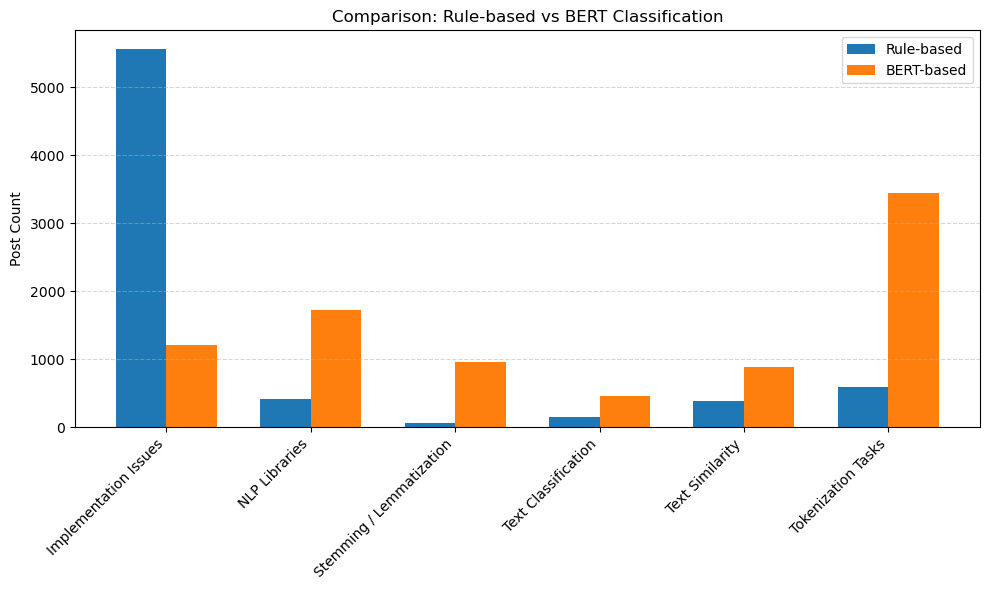

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df_rule = pd.read_csv("output/bert_rule_labelled.csv")
rule_labels = df_rule['category']

df_bert = pd.read_csv("output/bert_balanced_pred.csv")
bert_labels = df_bert['bert_prediction_mapped']

rule_counts = rule_labels.value_counts().sort_index()
bert_counts = bert_labels.value_counts().sort_index()

x_labels = sorted(set(rule_counts.index).union(set(bert_counts.index)))

rule_values = [rule_counts.get(label, 0) for label in x_labels]
bert_values = [bert_counts.get(label, 0) for label in x_labels]

print(df_bert['bert_prediction_mapped'].value_counts())
#plot
x = range(len(x_labels))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width / 2 for i in x], rule_values, width=bar_width, label="Rule-based")
plt.bar([i + bar_width / 2 for i in x], bert_values, width=bar_width, label="BERT-based")

plt.xticks(ticks=x, labels=x_labels, rotation=45, ha='right')
plt.ylabel("Post Count")
plt.title("Comparison: Rule-based vs BERT Classification")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
